In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

def do_classifier1(X, y, title='Disease', plot_shap=False,ax=None):
    y = y[y.index.isin(X.index)].sort_index()
    X = X[X.index.isin(y.index)].sort_index()
    classifier = GradientBoostingClassifier(n_estimators=2500, learning_rate=.01, max_depth=6,
                                            max_features=1, min_samples_leaf=10)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=104)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    if ax is None:
        fig, ax = plt.subplots(figsize=(90/25, 90/25), dpi=300)
    ax.set_facecolor('none')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.grid(True, linestyle=':', alpha=0.7)
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        fitted = classifier.fit(X.iloc[train], y.iloc[train])
        probas_ = fitted.predict_proba(X.iloc[test])
        fpr, tpr, _ = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, color='gray')

    ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='r', label='Chance', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='lightgray', alpha=.2,
                    label=r'± 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=7)
    ax.set_ylabel('True Positive Rate', fontsize=7)
    ax.set_title(f'Prediction of {title} from Microbiome', fontsize=7)
    ax.legend(loc="lower right", fontsize=6)
    ax.grid(True, linestyle=':', color='gray', alpha=0.5, linewidth=0.5)
    
    ax.tick_params(axis='both', which='major', labelsize=6)
    
    plt.tight_layout()
    #plt.show()
    
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
def boxplot_with_mannwhitney_final(data1, data2, labels, title, ax=None, save=False, exp_labels=False):
    # Perform Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    
    if ax is None:
        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(180 / 25.4 / 6 * 1.3, 2), dpi=300)
    
    # Create the boxplot
    bp = ax.boxplot([data1, data2], labels=labels, showfliers=False, widths=0.6)
    
    # Customize the plot
    ax.set_ylabel(title, fontsize=6)
    ax.set_xlabel('', fontsize=6)

    # Set style for median lines
    for median in bp['medians']:
        median.set(color='black', linewidth=1.5)
    
    # Set style for whiskers and caps
    for element in ['whiskers', 'caps']:
        for item in bp[element]:
            item.set(color='black', linewidth=1)
    
    # Find the highest and lowest point of the whiskers
    y_max = max(
        max(bp['whiskers'][0].get_ydata()),
        max(bp['whiskers'][1].get_ydata()),
        max(bp['whiskers'][2].get_ydata()),
        max(bp['whiskers'][3].get_ydata())
    )
    
    y_min = min(
        min(bp['whiskers'][0].get_ydata()),
        min(bp['whiskers'][1].get_ydata()),
        min(bp['whiskers'][2].get_ydata()),
        min(bp['whiskers'][3].get_ydata())
    )
    
    # Add asterisks based on the p-value
    if p_value < 0.001:
        annotation = '***'  # p < 0.001
    elif p_value < 0.01:
        annotation = '**'   # p < 0.01
    elif p_value < 0.05:
        annotation = '*'    # p < 0.05
    else:
        annotation = 'n.s.'  # not significant
    
    # Determine where to place the horizontal line and annotation
    line_height = y_max + (abs(y_max - y_min) * 0.05)  # 5% above the highest whisker
    annotation_height = y_max + (abs(y_max - y_min) * 0.08)  # 8% above the highest whisker
    
    # Display the asterisks above the boxes
    ax.text(1.5, annotation_height, annotation,  # Use the adjusted height for annotation
            horizontalalignment='center', fontweight='bold', fontsize=6)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    # Add a line connecting the boxes
    x1, x2 = 1, 2
    ax.plot([x1, x1, x2, x2], [line_height, annotation_height, annotation_height, line_height], lw=0.5, c='black')
    
    # Adjust y-axis limits to ensure room for the annotation and horizontal line
    ax.set_ylim(bottom=y_min - abs(y_max - y_min) * 0.1,  # Add space below the minimum whisker
                top=annotation_height + abs(y_max - y_min) * 0.1) 
    # Add a small buffer space above the annotation
    if exp_labels:
        def exp10_format(y, pos):
            return f"$10^{{{int(y)}}}$"
        ax.yaxis.set_major_formatter(FuncFormatter(exp10_format))
    
    
    # Set background color and frame
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(0.5)
    
    # Add grid
    ax.grid(True, axis='y', linestyle=':', color='gray', alpha=0.5, linewidth=0.5)
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=5, length=3, width=0.5)
    plt.xticks(rotation=45)
    ax.set_xticklabels(labels, fontweight='normal', fontsize=6)
    
    plt.tight_layout()
    
    if save:
        plt.savefig('{}.png'.format(title[:5]), 
                    dpi=300, bbox_inches='tight')


In [4]:
import os
os.chdir('C:\\Users\\godnean\Desktop')
os.chdir('HPP_resource\\Figure3')

C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and

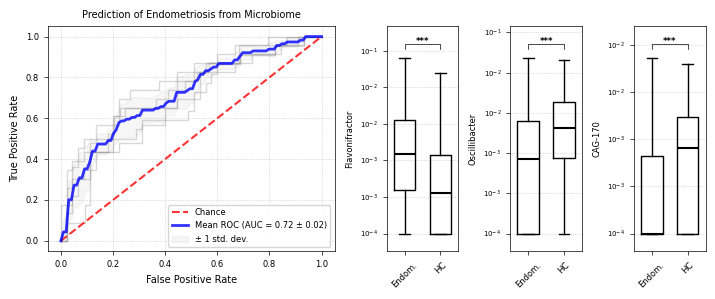

In [15]:
#X=pd.read_csv('endo_microbiome_matrix.csv', index_col=0).dropna(axis=1)
X=pd.read_csv('endo_microbiome_matrix.csv', index_col=0)
X['bmi']=X['bmi'].fillna(X['bmi'].mean())
y=X['endo']
del X['endo']
endo_index=y[y==1].index
not_endo_index=y[y!=1].index
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
# Set the style to match Nature Medicine guidelines
plt.style.use('default')
plt.rcParams.update({
 'font.sans-serif': ['Helvetica'],
    'font.size': 7,
    'axes.linewidth': 0.5,
    'axes.labelsize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'axes.spines.right': False,
    'axes.spines.top': False,
})

fig = plt.figure(figsize=(180 / 25.4,3))

# Create a GridSpec with 2 rows and 2 columns, with the bottom row spanning both columns

gs = gridspec.GridSpec(1, 4, width_ratios=[4,1,1,1])
# Top-left panel (Panel A)


# Bottom panel (Panel C, wider)
ax3 = fig.add_subplot(gs[0, 0])  # First column (wider)
do_classifier1(X,y, title='Endometriosis', ax=ax3)
# Adjust layout to prevent overlap


for i,col in enumerate(['Flavonifractor|2125.0', 'Oscillibacter|2105.0', 'CAG-170|2056.0']):
    ax = fig.add_subplot(gs[0, i+1])
    boxplot_with_mannwhitney_final(X.loc[endo_index,col], 
        X.loc[not_endo_index,col],['Endom.', 'HC'], col.split('|')[0],ax=ax,exp_labels=True)


plt.subplots_adjust(left=0.05, right=3, top=0.2, bottom=0.1, wspace=0.15)
plt.tight_layout()

# Save or show the figure
plt.savefig('10k_predicting_endometriosis_all_revision.png', dpi=300, bbox_inches='tight')

In [17]:
from utils import compare_2_groups

comparison_table1 = compare_2_groups(X, endo_index,  not_endo_index, group1_name='Endometriosis',
                                     group2_name='Healthy_control')

comparison_table1.to_csv('healthy_control_endometriosis_comparison.csv')

C:\Users\godnean\PycharmProjects\HPP_resource_code\utils.py:134: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison_table['mw_pvalue']=comparison_table['mw_pvalue'].fillna(1)


C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and

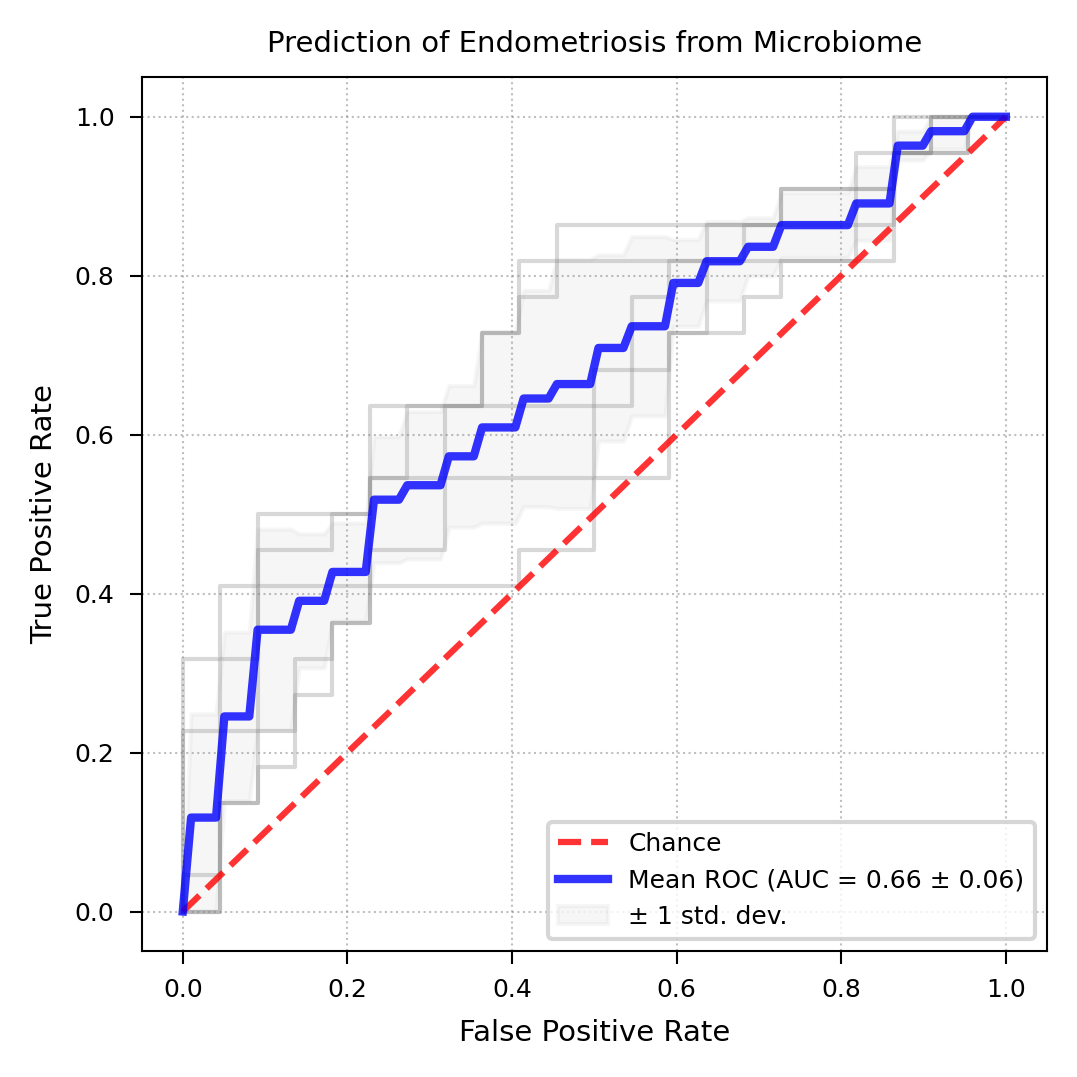

In [25]:
#X=pd.read_csv('endo_microbiome_matrix.csv', index_col=0).dropna(axis=1)
X1=pd.read_csv('endo_microbiome_matrix.csv', index_col=0).sample(frac=1)
X1=X1.groupby('endo').head(110).reset_index().set_index('index')
X1['bmi']=X1['bmi'].fillna(X['bmi'].mean())
y1=X1['endo']
del X1['endo']

filtered_microbes=(X1>-4).sum()[(X1>-4).sum()>50].index

do_classifier1(X1[filtered_microbes],y1, title='Endometriosis')

In [24]:
X1

,Sutterella|477.0,Sutterella|483.0,Akkermansia|490.0,Victivallis|493.0,Victivallis|494.0,UBA11452|498.0,51-20|531.0,Bifidobacterium|568.0,Bifidobacterium|571.0,Bifidobacterium|572.0,...,Alistipes|420.0,Alistipes|422.0,Alistipes|423.0,Alistipes|429.0,Tidjanibacter|434.0,Oxalobacter|448.0,Parasutterella|462.0,Mesosutterella|469.0,age,bmi
index,,,,,,,,,,,,,,,,,,,,,
157,-4.000000,-4.000000,-2.382241,-4.000000,-4.000000,-4.000000,-2.059454,-1.991858,-3.290279,-3.186841,...,-2.218827,-1.974928,-2.828700,-4.000000,-4.000000,-3.248854,-4.000000,-4.0,44.0,21.084337
301,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-3.905027,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.0,26.0,22.553696
88,-4.000000,-4.000000,-2.385776,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-3.461158,...,-4.000000,-4.000000,-1.337367,-4.000000,-1.719436,-4.000000,-4.000000,-4.0,29.0,23.333334
124,-4.000000,-4.000000,-4.000000,-3.613063,-3.523736,-2.847764,-4.000000,-2.956969,-2.906722,-2.999982,...,-3.447227,-2.672809,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.0,40.0,20.520735
187,-4.000000,-3.094659,-1.695386,-3.264118,-4.000000,-3.364656,-4.000000,-3.792870,-4.000000,-3.846285,...,-2.319077,-2.049772,-2.272839,-4.000000,-4.000000,-3.090061,-3.714967,-4.0,36.0,29.407597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,...,-2.124656,-2.632786,-1.445851,-4.000000,-4.000000,-4.000000,-4.000000,-4.0,42.0,30.655434
31,-1.466194,-4.000000,-2.486934,-4.000000,-4.000000,-4.000000,-4.000000,-2.563711,-4.000000,-2.048031,...,-2.553615,-2.772095,-4.000000,-4.000000,-4.000000,-4.000000,-3.268391,-4.0,25.0,21.504469
82,-1.711105,-4.000000,-3.923737,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-2.794950,-2.938879,...,-2.213245,-2.215874,-1.628736,-2.384187,-2.735520,-4.000000,-2.657841,-4.0,21.0,25.816629


C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and

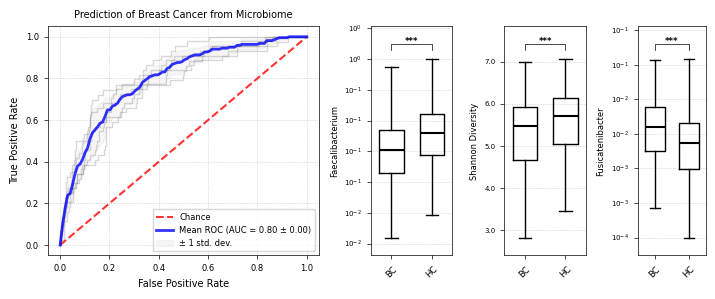

In [32]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from skbio.diversity.alpha import shannon
import matplotlib.gridspec as gridspec



fig = plt.figure(figsize=(180 / 25.4,3))

# Create a GridSpec with 2 rows and 2 columns, with the bottom row spanning both columns

gs = gridspec.GridSpec(1, 4, width_ratios=[4,1.2,1.2,1])
# Top-left panel (Panel A)

X=pd.read_csv('cancer_microbiome_matrix.csv', index_col=0)
diversity=X['diversity']
fecaulabacterium=X['fecaulabacterium']
del X['diversity']
del X['fecaulabacterium']
X['bmi']=X['bmi'].fillna(X['bmi'].mean())
X['age']=X['age'].fillna(X['age'].mean())
y=X['cancer']
del X['cancer']
cancer_index=y[y==1].index
not_cancer_index=y[y!=1].index
import matplotlib.pyplot as plt


# Bottom panel (Panel C, wider)
ax3 = fig.add_subplot(gs[0, 0])  # First column (wider)
do_classifier1(X,y, title='Breast Cancer', ax=ax3)
# Adjust layout to prevent overlap



XX=pd.DataFrame()
XX['Faecalibacterium|']=fecaulabacterium
XX['Shannon Diversity| ']=diversity
XX['Fusicatenibacter|Fusicatenibacter saccharivorans|2249.0']=X['Fusicatenibacter|Fusicatenibacter saccharivorans|2249.0']
for i,col in enumerate(['Faecalibacterium|', 'Shannon Diversity| ', 'Fusicatenibacter|Fusicatenibacter saccharivorans|2249.0']):
    ax = fig.add_subplot(gs[0, i+1])
    exp_labels=True
    if col=='Shannon Diversity| ':
        exp_labels=False
    boxplot_with_mannwhitney_final(XX.loc[cancer_index, col], 
        XX.loc[not_cancer_index, col],['BC', 'HC'], col.split('|')[0],ax=ax,exp_labels=exp_labels)


plt.subplots_adjust(left=0.05, right=3, top=0.2, bottom=0.1, wspace=0.2)
plt.tight_layout()

# Save or show the figure
plt.savefig('10k_predicting_cancer_all_revision.png', dpi=300, bbox_inches='tight')

for endometriosis and IBD the code is identical

C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\godnean\AppData\Local\Temp\ipykernel_84468\1813097617.py:32: DeprecationWarning: scipy.interp is deprecated and

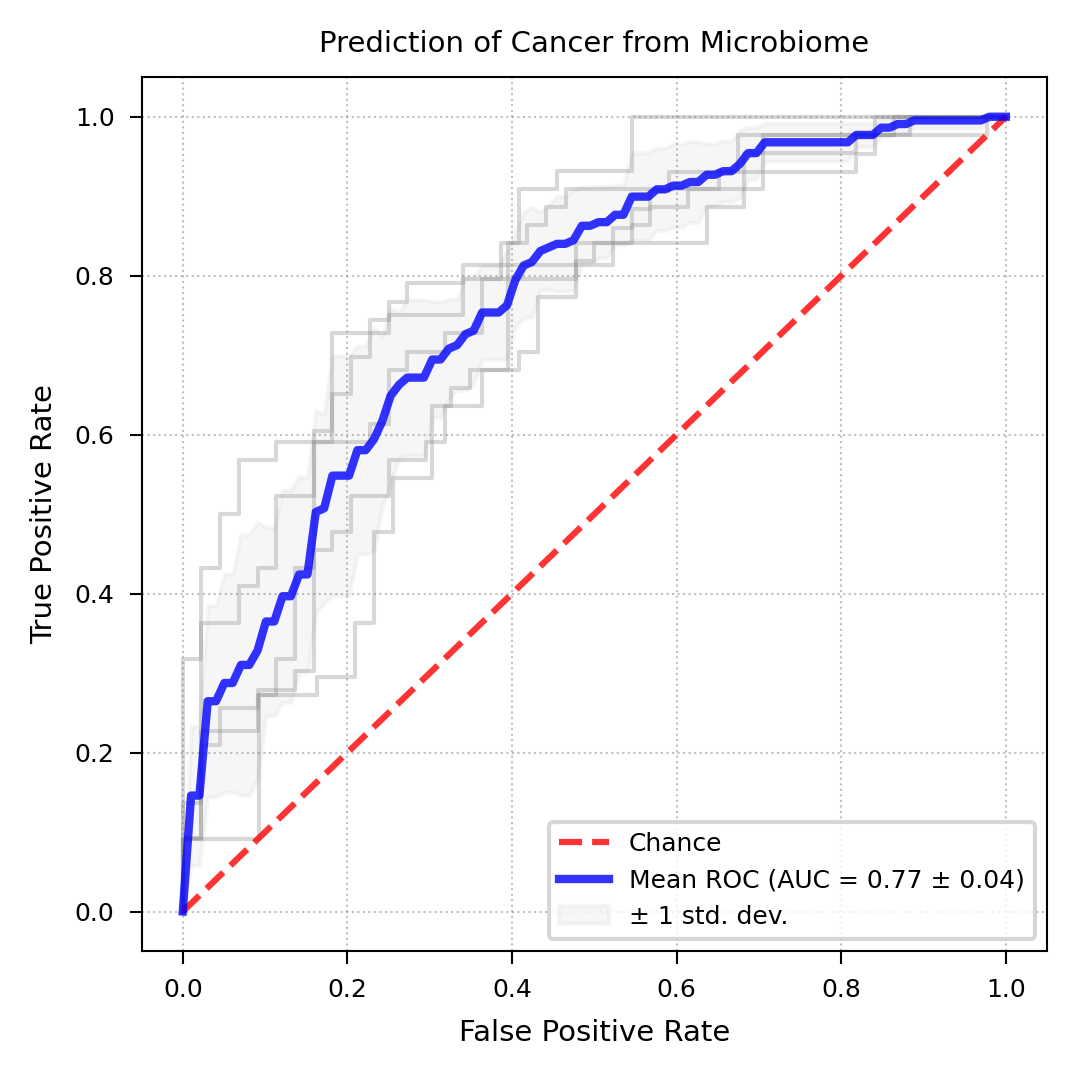

In [46]:
#X=pd.read_csv('endo_microbiome_matrix.csv', index_col=0).dropna(axis=1)
X1=pd.read_csv('cancer_microbiome_matrix_nf.csv', index_col=0).sample(frac=1)
del X1['diversity']
del X1['fecaulabacterium']
X1['bmi']=X1['bmi'].fillna(X['bmi'].mean())
X1['age']=X1['age'].fillna(X['age'].mean())
X1=X1.groupby('cancer').head(219).reset_index().set_index('index')

y1=X1['cancer']
del X1['cancer']

filtered_microbes=(X1>-4).sum()[(X1>-4).sum()>100].index

do_classifier1(X1[filtered_microbes],y1, title='Cancer')

In [44]:
X1

,Duodenibacillus|Duodenibacillus sp900552545|688.0,Duodenibacillus|unknown|689.0,Duodenibacillus|unknown|690.0,Duodenibacillus|unknown|691.0,Duodenibacillus|Duodenibacillus sp900552915|692.0,Duodenibacillus|Duodenibacillus sp003472385|693.0,Duodenibacillus|Duodenibacillus sp900538905|694.0,Duodenibacillus|Duodenibacillus massiliensis|695.0,Duodenibacillus|Duodenibacillus sp900544255|696.0,Duodenibacillus|unknown|697.0,...,Treponema_D|Treponema_D berlinense|19.0,Treponema_D|unknown|20.0,Treponema_D|Treponema_D succinifaciens|21.0,Treponema_D|Treponema_D sp002449305|22.0,Treponema_D|Treponema_D sp900541945|23.0,Treponema_D|Treponema_D sp002478955|24.0,age,bmi,diversity,fecaulabacterium
index,,,,,,,,,,,,,,,,,,,,,
1085,-4.0,-4.0,-4.0,-4.000000,-4.0,-4.000000,-4.0,-4.000000,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,46.0,30.486658,7.031321,-1.353712
150,-4.0,-4.0,-4.0,-4.000000,-4.0,-4.000000,-4.0,-2.083634,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,66.0,30.083319,5.296704,-1.668396
920,-4.0,-4.0,-4.0,-4.000000,-4.0,-4.000000,-4.0,-1.792227,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,53.0,25.792379,5.980718,-1.045857
1222,-4.0,-4.0,-4.0,-4.000000,-4.0,-4.000000,-4.0,-4.000000,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,41.0,24.007860,6.070285,-1.442800
61,-4.0,-4.0,-4.0,-4.000000,-4.0,-4.000000,-4.0,-4.000000,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,45.0,26.596556,4.447054,-1.177923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,-4.0,-4.0,-4.0,-4.000000,-4.0,-4.000000,-4.0,-4.000000,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,39.0,25.351562,4.365151,-1.946280
137,-4.0,-4.0,-4.0,-4.000000,-4.0,-4.000000,-4.0,-4.000000,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,52.0,25.468748,1.714059,-2.206988
207,-4.0,-4.0,-4.0,-4.000000,-4.0,-2.652114,-4.0,-4.000000,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,47.0,34.048443,5.040524,-1.354849
